In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
from scipy.io import loadmat
from pathlib import Path
import matplotlib.patches as patches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_rel
from scipy.signal import butter, filtfilt
import mne
import eeg_analysis.funcs4eeg as fe
import re
import imp
import ast
import behavior.func4behav as fb
imp.reload(fe)
imp.reload(fb)
import matplotlib
from scipy import signal
from scipy.signal import resample
from scipy.ndimage import zoom
import fathon
from fathon import fathonUtils as fu
from scipy.signal import butter, lfilter

# Generate tables

### ENDO

In [2]:
def align_slow(eeg, case, fs):
    if 'endo' in case:
        jump_from, jump_to = int((1.5+1+0.5)*fs), int((1.5+1+1)*fs)
    elif 'exo' in case:
        jump_from, jump_to = int((1.5+0.033*4+0.5)*fs), int((1.5+0.033*4+1)*fs)
    
    for channel in range(len(eeg)):
        eeg[channel] = np.concatenate((eeg[channel][:,:jump_from], eeg[channel][:,jump_to:]), axis=1)
        
    return eeg

case_title = 'endo'
case_list = [case_title+' fast', case_title+' slow']
if 'endo' in case_title:
    tmax_list = [1.5+1+0.5+0.05+0.2, 1.5+1+1+0.05+0.2]
else:
    tmax_list = [1.5+0.033*4+0.5+0.05+0.2, 1.5+0.033*4+1+0.05+0.2]

fs = 1200
for i, case in enumerate(case_list):
    tmax = tmax_list[i]
    watch = '1 fixation'
    tmin = 0 # include fix or not?

    highpass = None
    lowpass = None

    sb, sa, rb, ra = fe.pipeline_session_channel(case, watch, tmin, tmax, hipass=highpass, lopass=lowpass, baseline=(0,0), detrend=0)
    
    if 'slow' in case:
        # sham_before_slow = align_slow(sb, case, fs)
        # sham_after_slow = align_slow(sa, case, fs)
        # real_before_slow = align_slow(rb, case, fs)
        # real_after_slow = align_slow(ra, case, fs)

        sham_before_slow = sb
        sham_after_slow = sa
        real_before_slow = rb
        real_after_slow = ra

    else:
        sham_before_fast = sb
        sham_after_fast = sa
        real_before_fast = rb
        real_after_fast = ra

c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tes-attention\processing\behavior\func4behav.py:155: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavior_compare, new_row], ignore_index=True)
c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tes-attention\processing\behavior\func4behav.py:155: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavior_

In [3]:
def butter_bandpass(lowcut, highcut, fs, order):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def dfa_alpha(data, min_win=25, max_win=200):
    dfa_data = fu.toAggregated(data)
    pydfa = fathon.DFA(dfa_data)
    wins = fu.linRangeByStep(min_win, max_win)
    n,F = pydfa.computeFlucVec(wins, revSeg=True, polOrd=3)
    H, H_intercept = pydfa.fitFlucVec()
    return H

### Not align

In [4]:
# exclude fixation
endo_fast_stages = [[1.5, 1.5+1], [1.5+1, 1.5+1+0.5], [1.5, 1.5+1+0.5]]
endo_slow_stages = [[1.5, 1.5+1], [1.5+1, 1.5+1+1], [1.5, 1.5+1+1]]
exo_fast_stages = [[1.5+0.033*4, 1.5+0.033*4+0.5], [1, 1.5], [1, 1.5]] # the second and third ones are fake, only for occupy the place
exo_slow_stages = [[1.5+0.033*4, 1.5+0.033*4+1], [1, 1.5], [1, 1.5]]

if 'endo' in case_title:
    stages = [endo_fast_stages, endo_slow_stages]
else:
    stages = [exo_fast_stages, exo_slow_stages]

slow_sessions = [sham_before_slow, sham_after_slow, real_before_slow, real_after_slow]
fast_sessions = [sham_before_fast, sham_after_fast, real_before_fast, real_after_fast]

In [5]:
dfa_table_se = np.zeros((4, 32, 3)) # 4 sessions, 32 channels, 2 stages
dfa_table_num = np.zeros((4, 32, 3)) # 4 sessions, 32 channels, 2 stages

for channel in range(32):
    print(channel)
    for k in range(3): # stages
        print(stages[0][k])
        for i in range(4):
            print(i)
            tmp = np.empty(())
            fast_session = fast_sessions[i][channel]
            slow_session = slow_sessions[i][channel]
            for j, data in enumerate([fast_session, slow_session]):
                stage = stages[j][k]
                t_start, t_end = int(stage[0]*fs), int(stage[1]*fs)
                for trial_n in range(data.shape[0]):
                    one_trial = data[trial_n, t_start:t_end]
                    alpha = dfa_alpha(one_trial)
                    tmp = np.append(tmp, alpha)
            # tmp = fe.rm_outlier(tmp, lower_k=3, upper_k=100, verbose=False)
            mask = (tmp>0) & (tmp<2)
            filtered_tmp = tmp[mask]
            dfa_table_num[i, channel, k] = filtered_tmp.shape[0]
            dfa_table_se[i, channel, k] = filtered_tmp.std()/np.sqrt(filtered_tmp.shape[0])

np.save('dfa_se_'+case_title, dfa_table_se)
np.save('dfa_num_'+case_title, dfa_table_num)


0
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
1
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
2
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
3
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
4
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
5
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
6
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
7
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
8
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
9
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
10
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
11
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
12
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
13
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
14
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
15
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0]
0
1
2
3
16
[1.5, 2.5]
0
1
2
3
[2.5, 3.0]
0
1
2
3
[1.5, 3.0

### EXO

In [6]:
case_title = 'exo'
case_list = [case_title+' fast', case_title+' slow']
if 'endo' in case_title:
    tmax_list = [1.5+1+0.5+0.05+0.2, 1.5+1+1+0.05+0.2]
else:
    tmax_list = [1.5+0.033*4+0.5+0.05+0.2, 1.5+0.033*4+1+0.05+0.2]

fs = 1200
for i, case in enumerate(case_list):
    tmax = tmax_list[i]
    watch = '1 fixation'
    tmin = 0 # include fix or not?

    highpass = None
    lowpass = None

    sb, sa, rb, ra = fe.pipeline_session_channel(case, watch, tmin, tmax, hipass=highpass, lopass=lowpass, baseline=(0,0), detrend=0)
    
    if 'slow' in case:
        # sham_before_slow = align_slow(sb, case, fs)
        # sham_after_slow = align_slow(sa, case, fs)
        # real_before_slow = align_slow(rb, case, fs)
        # real_after_slow = align_slow(ra, case, fs)

        sham_before_slow = sb
        sham_after_slow = sa
        real_before_slow = rb
        real_after_slow = ra

    else:
        sham_before_fast = sb
        sham_after_fast = sa
        real_before_fast = rb
        real_after_fast = ra

# exclude fixation
endo_fast_stages = [[1.5, 1.5+1], [1.5+1, 1.5+1+0.5], [1.5, 1.5+1+0.5]]
endo_slow_stages = [[1.5, 1.5+1], [1.5+1, 1.5+1+1], [1.5, 1.5+1+1]]
exo_fast_stages = [[1.5+0.033*4, 1.5+0.033*4+0.5], [1, 1.5], [1, 1.5]] # the second and third ones are fake, only for occupy the place
exo_slow_stages = [[1.5+0.033*4, 1.5+0.033*4+1], [1, 1.5], [1, 1.5]]

if 'endo' in case_title:
    stages = [endo_fast_stages, endo_slow_stages]
else:
    stages = [exo_fast_stages, exo_slow_stages]

slow_sessions = [sham_before_slow, sham_after_slow, real_before_slow, real_after_slow]
fast_sessions = [sham_before_fast, sham_after_fast, real_before_fast, real_after_fast]

dfa_table_se = np.zeros((4, 32, 3)) # 4 sessions, 32 channels, 2 stages
dfa_table_num = np.zeros((4, 32, 3)) # 4 sessions, 32 channels, 2 stages

for channel in range(32):
    print(channel)
    for k in range(3): # stages
        print(stages[0][k])
        for i in range(4):
            print(i)
            tmp = np.empty(())
            fast_session = fast_sessions[i][channel]
            slow_session = slow_sessions[i][channel]
            for j, data in enumerate([fast_session, slow_session]):
                stage = stages[j][k]
                t_start, t_end = int(stage[0]*fs), int(stage[1]*fs)
                for trial_n in range(data.shape[0]):
                    one_trial = data[trial_n, t_start:t_end]
                    alpha = dfa_alpha(one_trial)
                    tmp = np.append(tmp, alpha)
            # tmp = fe.rm_outlier(tmp, lower_k=3, upper_k=100, verbose=False)
            mask = (tmp>0) & (tmp<2)
            filtered_tmp = tmp[mask]
            dfa_table_num[i, channel, k] = filtered_tmp.shape[0]
            dfa_table_se[i, channel, k] = filtered_tmp.std()/np.sqrt(filtered_tmp.shape[0])

np.save('dfa_se_'+case_title, dfa_table_se)
np.save('dfa_num_'+case_title, dfa_table_num)

c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tes-attention\processing\behavior\func4behav.py:155: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavior_compare, new_row], ignore_index=True)
c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tes-attention\processing\behavior\func4behav.py:155: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavior_

0
[1.6320000000000001, 2.132]
0
1
2
3
[1, 1.5]
0
1
2
3
[1, 1.5]
0
1
2
3
1
[1.6320000000000001, 2.132]
0
1
2
3
[1, 1.5]
0
1
2
3
[1, 1.5]
0
1
2
3
2
[1.6320000000000001, 2.132]
0
1
2
3
[1, 1.5]
0
1
2
3
[1, 1.5]
0
1
2
3
3
[1.6320000000000001, 2.132]
0
1
2
3
[1, 1.5]
0
1
2
3
[1, 1.5]
0
1
2
3
4
[1.6320000000000001, 2.132]
0
1
2
3
[1, 1.5]
0
1
2
3
[1, 1.5]
0
1
2
3
5
[1.6320000000000001, 2.132]
0
1
2
3
[1, 1.5]
0
1
2
3
[1, 1.5]
0
1
2
3
6
[1.6320000000000001, 2.132]
0
1
2
3
[1, 1.5]
0
1
2
3
[1, 1.5]
0
1
2
3
7
[1.6320000000000001, 2.132]
0
1
2
3
[1, 1.5]
0
1
2
3
[1, 1.5]
0
1
2
3
8
[1.6320000000000001, 2.132]
0
1
2
3
[1, 1.5]
0
1
2
3
[1, 1.5]
0
1
2
3
9
[1.6320000000000001, 2.132]
0
1
2
3
[1, 1.5]
0
1
2
3
[1, 1.5]
0
1
2
3
10
[1.6320000000000001, 2.132]
0
1
2
3
[1, 1.5]
0
1
2
3
[1, 1.5]
0
1
2
3
11
[1.6320000000000001, 2.132]
0
1
2
3
[1, 1.5]
0
1
2
3
[1, 1.5]
0
1
2
3
12
[1.6320000000000001, 2.132]
0
1
2
3
[1, 1.5]
0
1
2
3
[1, 1.5]
0
1
2
3
13
[1.6320000000000001, 2.132]
0
1
2
3
[1, 1.5]
0
1
2
3
[1, 1

### Fixation

In [8]:
case_title = 'all'
case = 'all'

fs = 1200

watch = '1 fixation'
tmin = 0 # include fix or not?
tmax = 1.5

highpass = None
lowpass = None

sb, sa, rb, ra = fe.pipeline_session_channel(case, watch, tmin, tmax, hipass=highpass, lopass=lowpass, baseline=(0,0), detrend=0)

stage = [0, 1.5]
sessions = [sb, sa, rb, ra]

dfa_table_se = np.zeros((4, 32)) # 4 sessions, 32 channels, 2 stages
dfa_table_num = np.zeros((4, 32)) # 4 sessions, 32 channels, 2 stages

for channel in range(32):
    print(channel)
    for i in range(4):
        print(i)
        tmp = np.empty(())
        data = sessions[i][channel]
        t_start, t_end = int(stage[0]*fs), int(stage[1]*fs)
        for trial_n in range(data.shape[0]):
            one_trial = data[trial_n, t_start:t_end]
            alpha = dfa_alpha(one_trial)
            tmp = np.append(tmp, alpha)
        # tmp = fe.rm_outlier(tmp, lower_k=3, upper_k=100, verbose=False)
        mask = (tmp>0) & (tmp<2)
        filtered_tmp = tmp[mask]
        dfa_table_num[i, channel] = filtered_tmp.shape[0]
        dfa_table_se[i, channel] = filtered_tmp.std()/np.sqrt(filtered_tmp.shape[0])

np.save('dfa_se_fixation', dfa_table_se)
np.save('dfa_num_fixation', dfa_table_num)

c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tes-attention\processing\behavior\func4behav.py:155: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavior_compare, new_row], ignore_index=True)


0
0
1
2
3
1
0
1
2
3
2
0
1
2
3
3
0
1
2
3
4
0
1
2
3
5
0
1
2
3
6
0
1
2
3
7
0
1
2
3
8
0
1
2
3
9
0
1
2
3
10
0
1
2
3
11
0
1
2
3
12
0
1
2
3
13
0
1
2
3
14
0
1
2
3
15
0
1
2
3
16
0
1
2
3
17
0
1
2
3
18
0
1
2
3
19
0
1
2
3
20
0
1
2
3
21
0
1
2
3
22
0
1
2
3
23
0
1
2
3
24
0
1
2
3
25
0
1
2
3
26
0
1
2
3
27
0
1
2
3
28
0
1
2
3
29
0
1
2
3
30
0
1
2
3
31
0
1
2
3


In [ ]:
# np.save('dfa_table_'+case_title, dfa_table)
# dfa_table = np.load('dfa_table_'+case_title+'.npy')

In [ ]:
# band = 0
# fast, slow = bp_table[0,0,:,band], bp_table[0,1,:,band]

# plt.scatter(range(len(fast)), fast, color='blue', label='fast')
# plt.scatter(range(len(slow)), slow, color='red', label='slow')
# plt.title(band)
# plt.legend()
# plt.ylim([0, 7e-8])
# plt.show()

# Analyze

In [2]:
endo_means, exo_means, fix_means = np.load('dfa_data/dfa_mean_endo.npy'), np.load('dfa_data/dfa_mean_exo.npy'), np.load('dfa_data/dfa_mean_fixation.npy')
exo_means = exo_means[:, :, 0]
endo_nums, exo_nums, fix_nums = np.load('dfa_data/dfa_num_endo.npy'), np.load('dfa_data/dfa_num_exo.npy'), np.load('dfa_data/dfa_num_fixation.npy')
exo_nums = exo_nums[:, :, 0]
endo_se, exo_se, fix_se = np.load('dfa_data/dfa_se_endo.npy'), np.load('dfa_data/dfa_se_exo.npy'), np.load('dfa_data/dfa_se_fixation.npy')
exo_se = exo_se[:, :, 0]

print(np.min(fix_means), np.max(fix_means))

1.1402255256283456 1.4041407412572193


### DFA subtracts

In [3]:
# use wait for cue for endo
endo_dfa_subtracts, exo_dfa_subtracts, fix_dfa_subtracts = np.zeros((2, 32)),  np.zeros((2, 32)),  np.zeros((2, 32))
endo_dfa_subtracts[0,:], endo_dfa_subtracts[1,:] = endo_means[1,:,1] - endo_means[0,:,1], endo_means[3,:,1] - endo_means[2,:,1]
exo_dfa_subtracts[0,:], exo_dfa_subtracts[1,:] = exo_means[1,:] - exo_means[0,:], exo_means[3,:] - exo_means[2,:]
fix_dfa_subtracts[0,:], fix_dfa_subtracts[1,:] = fix_means[1,:] - fix_means[0,:], fix_means[3,:] - fix_means[2,:]

endo_se_subtracts, exo_se_subtracts, fix_se_subtracts = np.zeros((2, 32)), np.zeros((2, 32)), np.zeros((2, 32))
endo_se_subtracts[0,:], endo_se_subtracts[1,:] = np.sqrt(endo_se[1,:,1]**2 + endo_se[0,:,1]**2), np.sqrt(endo_se[3,:,1]**2 + endo_se[2,:,1]**2)
exo_se_subtracts[0,:], exo_se_subtracts[1,:] = np.sqrt(exo_se[1,:]**2 + exo_se[0,:]**2), np.sqrt(exo_se[3,:]**2 + exo_se[2,:]**2)
fix_se_subtracts[0,:], fix_se_subtracts[1,:] = np.sqrt(fix_se[1,:]**2 + fix_se[0,:]**2), np.sqrt(fix_se[3,:]**2 + fix_se[2,:]**2)

endo_num_subtracts, exo_num_subtracts, fix_num_subtracts = np.zeros((2, 32)), np.zeros((2, 32)), np.zeros((2, 32))
endo_num_subtracts[0,:], endo_num_subtracts[1,:] = endo_nums[1,:,1] + endo_nums[0,:,1], endo_nums[3,:,1] + endo_nums[2,:,1]
exo_num_subtracts[0,:], exo_num_subtracts[1,:] = exo_nums[1,:] + exo_nums[0,:], exo_nums[3,:] + exo_nums[2,:]
fix_num_subtracts[0,:], fix_num_subtracts[1,:] = fix_nums[1,:] + fix_nums[0,:], fix_nums[3,:] + fix_nums[2,:]

dfa_subtracts, se_subtracts, num_subtracts = np.zeros((2, 32, 3)), np.zeros((2, 32, 3)), np.zeros((2, 32, 3))
dfa_subtracts[:,:,0], dfa_subtracts[:,:,1], dfa_subtracts[:,:,2] = fix_dfa_subtracts, endo_dfa_subtracts, exo_dfa_subtracts
se_subtracts[:,:,0], se_subtracts[:,:,1], se_subtracts[:,:,2] = fix_se_subtracts, endo_se_subtracts, exo_se_subtracts
num_subtracts[:,:,0], num_subtracts[:,:,1], num_subtracts[:,:,2] = fix_num_subtracts, endo_num_subtracts, exo_num_subtracts

# common increase / decrease
dfa_subtracts_positive = np.where(dfa_subtracts>0, 1, 0)
dfa_subtracts_negative = np.where(dfa_subtracts<0, 1, 0)
sham_positive = dfa_subtracts_positive[0,:,0] * dfa_subtracts_positive[0,:,1] * dfa_subtracts_positive[0,:,2]
sham_negative = dfa_subtracts_negative[0,:,0] * dfa_subtracts_negative[0,:,1] * dfa_subtracts_negative[0,:,2]
real_positive = dfa_subtracts_positive[1,:,0] * dfa_subtracts_positive[1,:,1] * dfa_subtracts_positive[1,:,2]
real_negative = dfa_subtracts_negative[1,:,0] * dfa_subtracts_negative[1,:,1] * dfa_subtracts_negative[1,:,2]
sham_increase_channels = np.where(sham_positive==1)[0]
sham_decrease_channels = np.where(sham_negative==1)[0]
real_increase_channels = np.where(real_positive==1)[0]
real_decrease_channels = np.where(real_negative==1)[0]

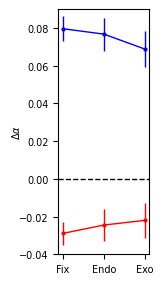

In [5]:
def calculate_grand_mean_and_se(means, ses, sample_sizes):
     # Number of cases is the number of rows in the input arrays
    num_cases = means.shape[1]

    # Initialize arrays to store the grand mean and standard error for each case
    grand_means = np.zeros(num_cases)
    grand_ses = np.zeros(num_cases)

    for i in range(num_cases):
        # Calculate the grand mean for this case
        grand_means[i] = np.mean(means[:, i])
        
        # Calculate the weighted sum of squared standard errors for this case
        weighted_ses_squared = np.sum((sample_sizes[:, i] - 1) * ses[:, i]**2)
        
        # Calculate the total degrees of freedom for this case
        total_degrees_of_freedom = np.sum(sample_sizes[:, i] - 1)
        
        # Calculate the weighted variance for this case
        weighted_variance = weighted_ses_squared / total_degrees_of_freedom
        
        # Calculate the standard error of the grand mean for this case
        grand_ses[i] = np.sqrt(weighted_variance / means.shape[1])
    
    return grand_means, grand_ses


# Set up the figure and axes
case_names = ['Fix', 'Endo', 'Exo']
# ylims = [[-3e-8, 3e-8], [-3e-8, 3e-8], [-3e-8, 3e-8], [-1e-8, 1e-8]]
# subtract_threshold = [0.25e-8, 0.25e-8, 0.25e-8, 0.25e-8]
channels = [24, 25, 26, 28]
# fig, axes = plt.subplots(nrows=1, ncols=len(band_names), figsize=(12, 5))

# for band, band_name in enumerate(band_names):
cm = 1/2.54
fig, ax = plt.subplots(figsize=(3.78*cm, 7*cm))
# ax = axes[band]
# sham power increase
line_width = 1
marker_size = 2

sham = dfa_subtracts[0,channels,:]
sham_ses = se_subtracts[0,channels,:]
sham_mean_grand, sham_ses_grand  = calculate_grand_mean_and_se(sham, sham_ses, num_subtracts[0,channels,:])
ax.errorbar(case_names, sham_mean_grand, yerr=sham_ses_grand, color='blue', label='Sham increase', marker='o', linestyle='-', linewidth = line_width, markersize=marker_size)

real = dfa_subtracts[1,channels,:]
real_ses = se_subtracts[1,channels,:]
real_mean_grand, real_ses_grand  = calculate_grand_mean_and_se(real, real_ses, num_subtracts[1,channels,:])
ax.errorbar(case_names, real_mean_grand, yerr=real_ses_grand, color='red', label='Real increase', marker='o', linestyle='-', linewidth = line_width, markersize=marker_size)


ax.axhline(y=0, color='black', linestyle='--', linewidth=line_width)
ax.set_ylim([-0.04, 0.09])
# ax.set_xlabel('Trial type')
ax.set_ylabel('$\u0394$$\u03B1$', labelpad=-2)

matplotlib.rcParams.update({'font.size': 7})
fig.subplots_adjust(left=0.35, bottom=0.08, right=0.96, top=0.97)
# plt.subplots_adjust(wspace=0.3)
# plt.tight_layout()
save_path = os.path.join('..', '..', '..', '..', 'paper', 'Figure 5', 'alpha_change.eps')
plt.savefig(save_path, format='eps')
plt.show()
